✓ Data loaded: 7,140 rows
ℹ No forecasts found - showing historical data only

Analyzing 16 weeks from 2025-01-27/2025-02-02 to 2025-05-19/2025-05-25
Players in dataset: 22


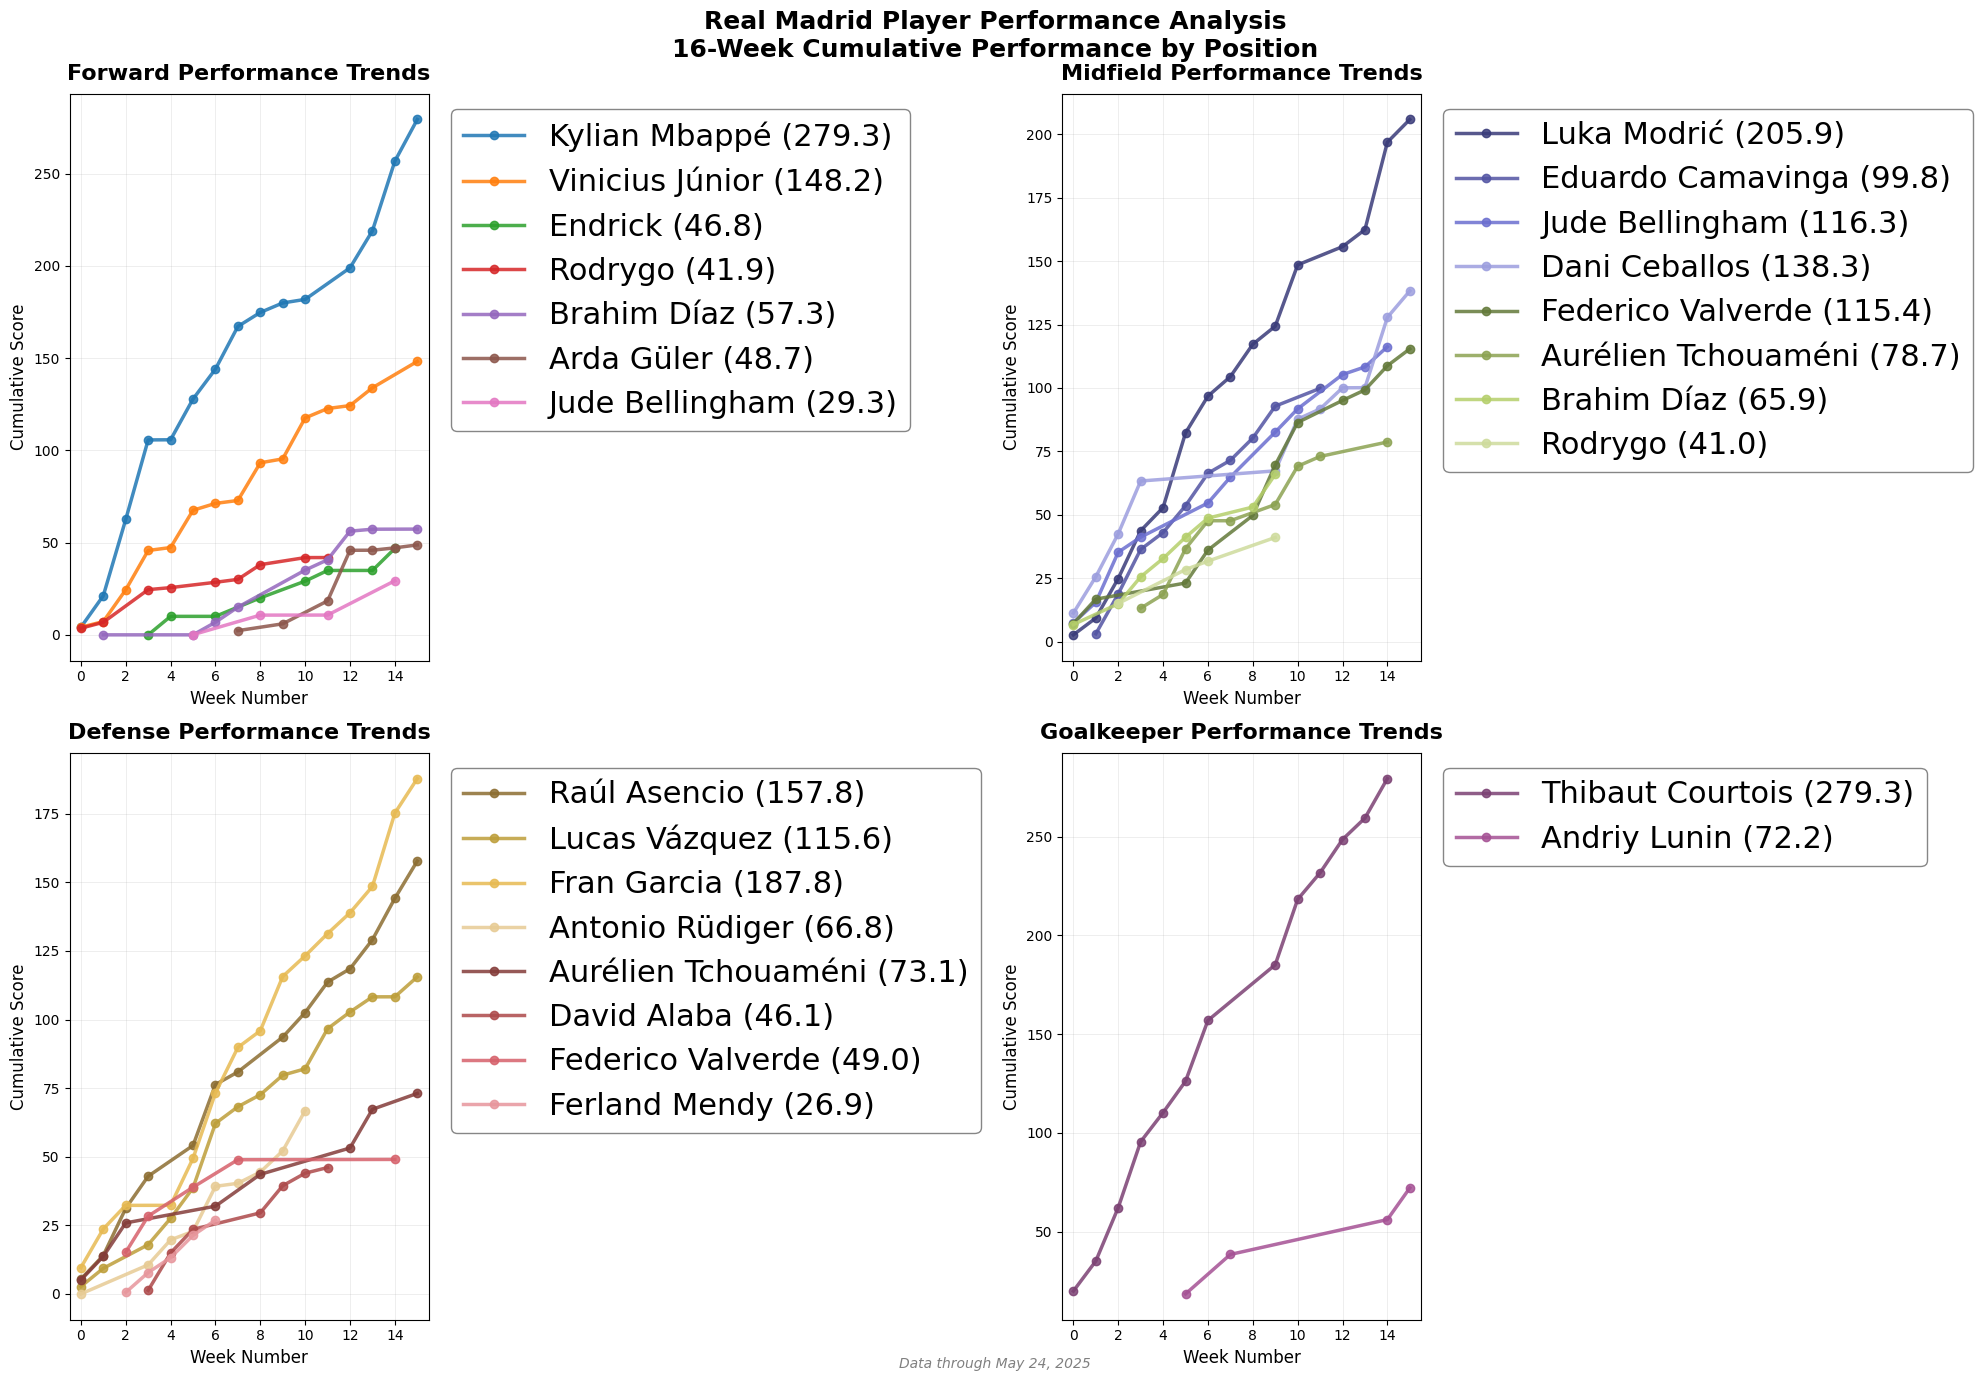


📊 Summary Statistics:
  Forward: 8 players, avg score: 7.60
  Midfield: 11 players, avg score: 7.79
  Defense: 11 players, avg score: 7.20
  Goalkeeper: 2 players, avg score: 15.98

📊 Performance Summary by Position:

Forward:
Position          Player  Avg Score  Total Score  Games
 Forward   Kylian Mbappé      13.30       279.29     21
 Forward Jude Bellingham       7.33        29.32      4
 Forward Vinicius Júnior       7.06       148.18     21
 Forward      Arda Güler       6.96        48.74      7
 Forward     Brahim Díaz       5.73        57.31     10

Midfield:
Position            Player  Avg Score  Total Score  Games
Midfield     Dani Ceballos       9.88       138.27     14
Midfield       Luka Modrić       9.80       205.89     21
Midfield        Arda Güler       8.37        41.86      5
Midfield Federico Valverde       8.24       115.42     14
Midfield   Jude Bellingham       7.75       116.25     15

Defense:
Position              Player  Avg Score  Total Score  Games
 Defens

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')  # Changed from seaborn-v0_8-darkgrid which might not exist
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Load data
path = '/Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/02_Feature_Engineering/outputs/real_madrid_rebalanced_scores.csv'
forecast_path = '/Users/home/Documents/GitHub/Capstone/future_performance_forecasts.csv'

try:
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"✓ Data loaded: {df.shape[0]:,} rows")
except Exception as e:
    print(f"✗ Error loading data: {e}")
    raise SystemExit  # Changed from exit() which can cause issues

# Try loading forecasts
try:
    forecasts_df = pd.read_csv(forecast_path)
    HAS_FORECASTS = True
    print(f"✓ Forecasts loaded: {forecasts_df.shape[0]:,} rows")
except:
    HAS_FORECASTS = False
    forecasts_df = None
    print("ℹ No forecasts found - showing historical data only")

# Prepare data
df['Week'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.year

# Get last 16 weeks of data
latest_date = df['Date'].max()
cutoff_date = latest_date - timedelta(weeks=16)
recent_data = df[df['Date'] >= cutoff_date].copy()

# Create week ranking for consistent x-axis
week_periods = recent_data['Date'].dt.to_period('W')
week_order = sorted(week_periods.unique())
week_mapping = {week: idx for idx, week in enumerate(week_order)}
recent_data['WeekRank'] = week_periods.map(week_mapping)

print(f"\nAnalyzing {len(week_order)} weeks from {week_order[0]} to {week_order[-1]}")
print(f"Players in dataset: {recent_data['Player'].nunique()}")

# Create figure with better layout
fig, axes = plt.subplots(2, 2, figsize=(20, 14))  # Simplified subplot creation
axes = axes.flatten()

# Position configuration with distinct color palettes
positions = ['Forward', 'Midfield', 'Defense', 'Goalkeeper']
position_colors = {
    'Forward': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],
    'Midfield': ['#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252', '#b5cf6b', '#cedb9c'],
    'Defense': ['#8c6d31', '#bd9e39', '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b', '#e7969c'],
    'Goalkeeper': ['#7b4173', '#a55194', '#ce6dbd', '#de9ed6', '#3182bd', '#6baed6', '#9ecae1', '#c6dbef']
}

# Process each position
for pos_idx, position in enumerate(positions):
    ax = axes[pos_idx]
    pos_data = recent_data[recent_data['Position_Group'] == position]
    
    if len(pos_data) == 0:
        ax.text(0.5, 0.5, f'No data for {position}', 
                transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title(f'{position} - No Data Available', fontsize=16)
        continue
    
    # Get top players (minimum 3 games for better representation)
    player_games = pos_data.groupby('Player').size()
    eligible_players = player_games[player_games >= 3].sort_values(ascending=False).head(8).index
    
    # Color palette for this position
    colors = position_colors[position]
    
    # Plot each player's cumulative performance
    for player_idx, player in enumerate(eligible_players):
        player_data = pos_data[pos_data['Player'] == player].sort_values('Date')
        
        # Calculate cumulative score
        player_data = player_data.copy()  # Avoid SettingWithCopyWarning
        player_data['CumulativeScore'] = player_data['Rebalanced_Score'].cumsum()
        
        # Aggregate by week (taking last cumulative value)
        weekly_data = player_data.groupby('WeekRank').agg({
            'CumulativeScore': 'last',
            'Date': 'first',
            'Rebalanced_Score': 'sum'
        }).reset_index().sort_values('WeekRank')
        
        if len(weekly_data) == 0:  # Safety check
            continue
            
        # Plot historical data
        ax.plot(weekly_data['WeekRank'], weekly_data['CumulativeScore'],
               marker='o', linewidth=2.5, markersize=6,
               color=colors[player_idx % len(colors)], alpha=0.85,
               label=f"{player[:20]} ({weekly_data['CumulativeScore'].iloc[-1]:.1f})")
        
        # Add forecast if available
        if HAS_FORECASTS and forecasts_df is not None:
            player_forecast = forecasts_df[
                (forecasts_df['Player'] == player) & 
                (forecasts_df['Position'] == position)
            ]
            
            if not player_forecast.empty and len(weekly_data) > 0:
                # Forecast parameters
                predicted_weekly = player_forecast['Predicted_Score'].iloc[0]
                last_week = weekly_data['WeekRank'].max()
                last_cumulative = weekly_data['CumulativeScore'].iloc[-1]
                
                # Generate 4-week forecast
                forecast_weeks = np.arange(last_week + 1, last_week + 5)
                forecast_cumulative = last_cumulative + predicted_weekly * np.arange(1, 5)
                
                # Plot forecast with dashed line
                ax.plot(forecast_weeks, forecast_cumulative,
                       marker='s', markersize=6, linewidth=2,
                       color=colors[player_idx % len(colors)], linestyle='--', alpha=0.6)
                
                # Label final forecast value
                ax.annotate(f'+{forecast_cumulative[-1] - last_cumulative:.0f}',
                          xy=(forecast_weeks[-1], forecast_cumulative[-1]),
                          xytext=(5, 5), textcoords='offset points',
                          fontsize=9, color=colors[player_idx % len(colors)], 
                          fontweight='bold', alpha=0.8)
    
    # Add forecast separator line
    if HAS_FORECASTS and len(recent_data) > 0:
        max_week = recent_data['WeekRank'].max()
        ax.axvline(x=max_week + 0.5, color='gray', linestyle=':', 
                  linewidth=2, alpha=0.5, zorder=0)
        
        # Add "Forecast" label
        y_lim = ax.get_ylim()
        if y_lim[1] > y_lim[0]:  # Check if y-limits are valid
            y_pos = y_lim[1] * 0.95
            ax.text(max_week + 2.5, y_pos, 'FORECAST', 
                   ha='center', va='top', fontsize=11,
                   color='gray', fontweight='bold', alpha=0.7)
    
    # Styling
    ax.set_title(f'{position} Performance Trends', fontsize=16, fontweight='bold', pad=10)
    ax.set_xlabel('Week Number', fontsize=12)
    ax.set_ylabel('Cumulative Score', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Legend positioning
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
             fontsize=22, framealpha=0.95, edgecolor='gray')
    
    # Set x-axis limits to show all data plus forecast
    if HAS_FORECASTS and len(recent_data) > 0:
        max_week = recent_data['WeekRank'].max()
        ax.set_xlim(-0.5, max_week + 4.5)
    elif len(recent_data) > 0:
        ax.set_xlim(-0.5, recent_data['WeekRank'].max() + 0.5)

# Main title
title = 'Real Madrid Player Performance Analysis\n'
title += '16-Week Cumulative Performance by Position'
if HAS_FORECASTS:
    title += ' with 4-Week Forecasts'

plt.suptitle(title, fontsize=18, fontweight='bold', y=0.98)

# Add footer info
fig.text(0.5, 0.01, f'Data through {latest_date.strftime("%B %d, %Y")}', 
         ha='center', fontsize=10, style='italic', color='gray')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Summary Statistics:")
for position in positions:
    pos_players = recent_data[recent_data['Position_Group'] == position]['Player'].nunique()
    if pos_players > 0:
        avg_score = recent_data[recent_data['Position_Group'] == position]['Rebalanced_Score'].mean()
        print(f"  {position}: {pos_players} players, avg score: {avg_score:.2f}")


#Real Madrid Cumulative Performance by Position (Rebalanced Scores)
# Performance Summary Table
print("\n📊 Performance Summary by Position:")
print("="*80)

# Create summary data for each position
summary_data = []

for position in positions:
    pos_data = recent_data[recent_data['Position_Group'] == position]
    
    if len(pos_data) > 0:
        # Get top 5 players by average score
        player_avg = pos_data.groupby('Player')['Rebalanced_Score'].agg(['mean', 'sum', 'count'])
        player_avg = player_avg[player_avg['count'] >= 3].sort_values('mean', ascending=False).head(5)
        
        for player, stats in player_avg.iterrows():
            summary_data.append({
                'Position': position,
                'Player': player[:25],  # Truncate long names
                'Avg Score': stats['mean'],
                'Total Score': stats['sum'],
                'Games': int(stats['count'])
            })

# Create DataFrame and display
summary_df = pd.DataFrame(summary_data)

# Display by position
for position in positions:
    pos_summary = summary_df[summary_df['Position'] == position]
    if len(pos_summary) > 0:
        print(f"\n{position}:")
        print(pos_summary.to_string(index=False, float_format='%.2f'))

# Overall statistics
print("\n\n📈 Overall Statistics:")
print(f"Total unique players analyzed: {recent_data['Player'].nunique()}")
print(f"Total matches analyzed: {len(recent_data)}")
print(f"Average score across all positions: {recent_data['Rebalanced_Score'].mean():.2f}")

# Forecast summary if available
if HAS_FORECASTS and forecasts_df is not None:
    print("\n\n🔮 Forecast Summary (Next 4 Weeks):")
    forecast_summary = forecasts_df.groupby('Position').agg({
        'Predicted_Score': ['mean', 'count'],
        'Score_Change': 'mean'
    }).round(2)
    forecast_summary.columns = ['Avg Predicted', 'Player Count', 'Avg Change']
    print(forecast_summary)

🧠 TRAINING ADDITIONAL MODELS: NEURAL NETWORK & ENSEMBLE
Creating position datasets...
  Forward: 1585 train, 110 test samples
  Midfield: 1724 train, 99 test samples
  Defense: 1718 train, 105 test samples
  Goalkeeper: 469 train, 29 test samples

🌲 Training base models (RF & XGBoost)...
  Forward - RF R²: 0.987, XGB R²: 0.985
  Midfield - RF R²: 0.330, XGB R²: 0.303
  Defense - RF R²: 0.935, XGB R²: 0.929
  Goalkeeper - RF R²: 0.822, XGB R²: 0.843

🧠 NEURAL NETWORK TRAINING
--------------------------------------------------

Training Neural Network for Forward...
  Training R²: 0.990, MAE: 0.563
  Testing R²:  0.962, MAE: 0.703
  Iterations: 295

Training Neural Network for Midfield...
  Training R²: 0.493, MAE: 2.148
  Testing R²:  0.418, MAE: 2.115
  Iterations: 86

Training Neural Network for Defense...
  Training R²: 0.933, MAE: 0.901
  Testing R²:  0.937, MAE: 0.844
  Iterations: 126

Training Neural Network for Goalkeeper...
  Training R²: 0.936, MAE: 0.274
  Testing R²:  0.904,

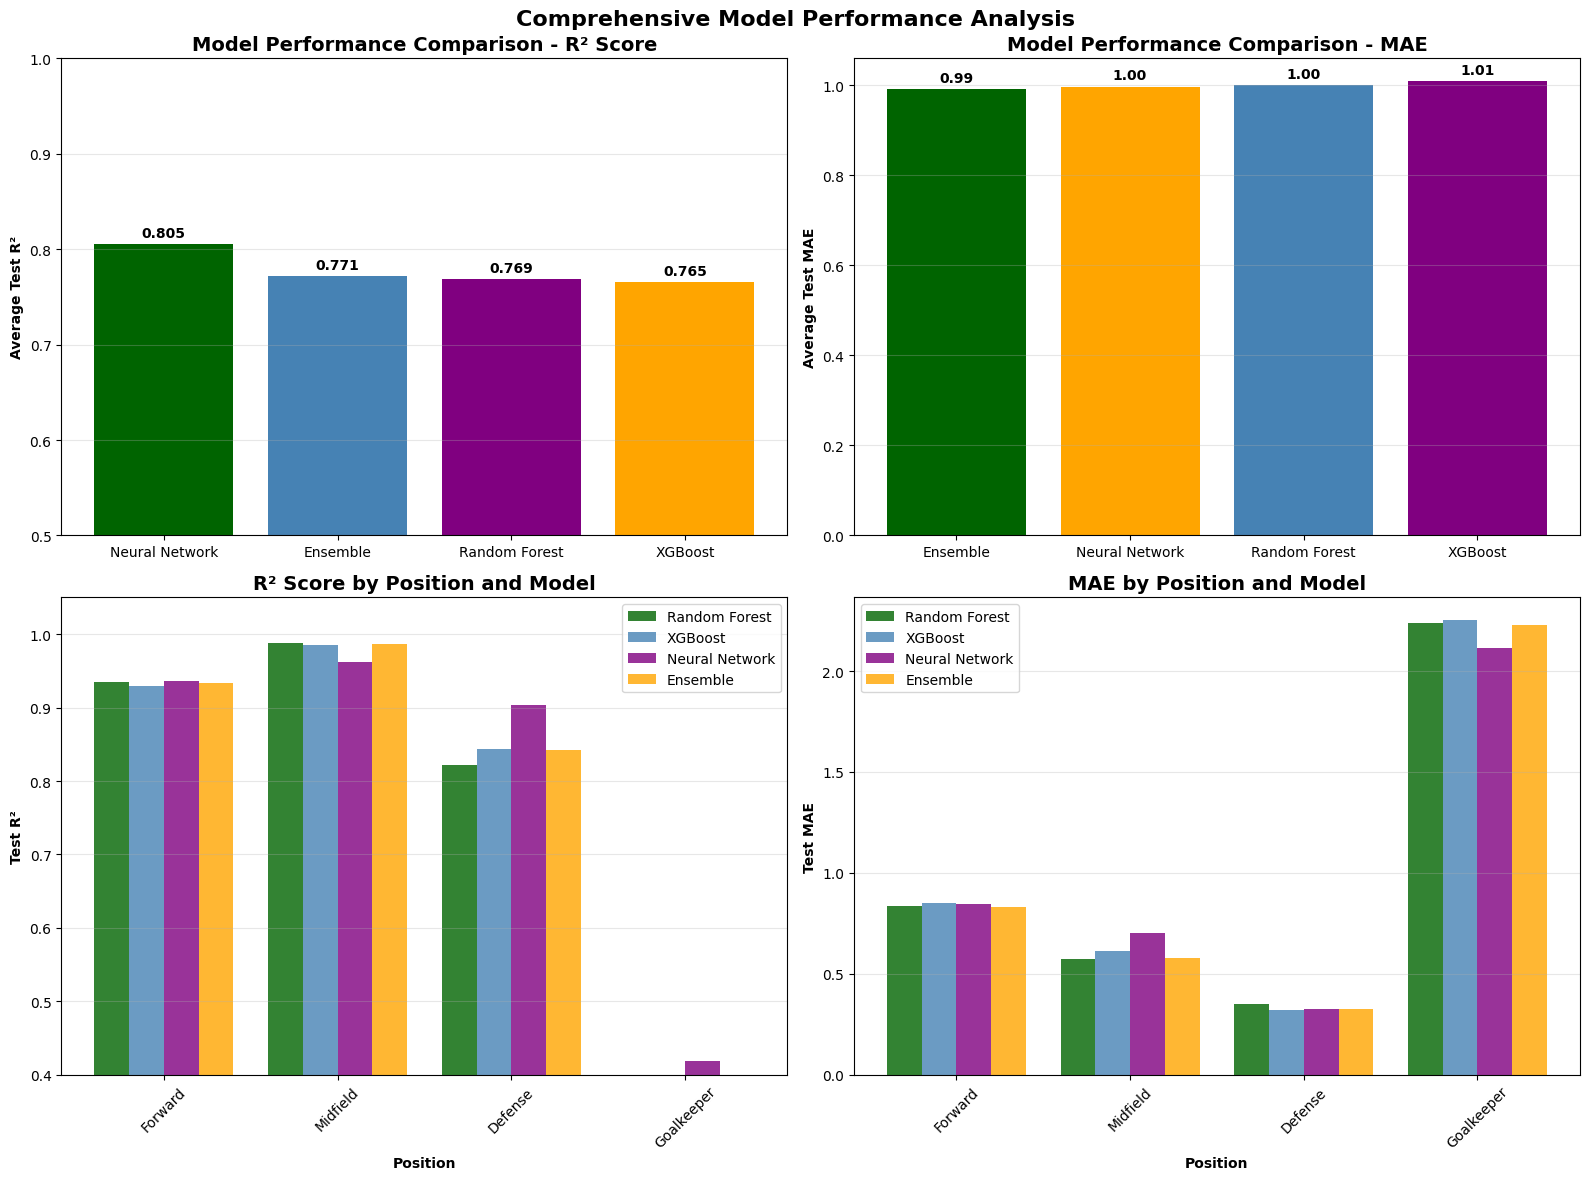


📊 DETAILED MODEL COMPARISON:
--------------------------------------------------------------------------------
Model                Avg R²     Avg MAE    Best Position   Worst Position 
--------------------------------------------------------------------------------
Random Forest        0.769      1.00       Forward         Midfield       
XGBoost              0.765      1.01       Forward         Midfield       
Neural Network       0.805      1.00       Forward         Midfield       
Ensemble             0.771      0.99       Forward         Midfield       

🎯 IMPROVEMENTS OVER RANDOM FOREST:
--------------------------------------------------
XGBoost:
  R² Score: ↓ 0.4%
  MAE:      ↑ 0.9%
Neural Network:
  R² Score: ↑ 4.7%
  MAE:      ↓ 0.4%
Ensemble:
  R² Score: ↑ 0.4%
  MAE:      ↓ 0.9%

🏆 MODEL TRAINING COMPLETE!
Trained 4 Neural Network models
Trained 4 Ensemble models
Trained 4 Random Forest models
Trained 4 XGBoost models


In [6]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 TRAINING ADDITIONAL MODELS: NEURAL NETWORK & ENSEMBLE")
print("="*80)

# First, we need to recreate the base models and datasets from the previous analysis
# Using the same data and position-specific metrics from the earlier code

# Create Week column if needed
if 'Week' not in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Week'] = df['Date'].dt.isocalendar().week

# Create per-90 features
def create_per90_features(df):
    df_per90 = df.copy()
    df_per90['Min_Safe'] = df_per90['Min'].replace(0, 1)
    
    volume_stats = [
        ' Gls', ' Ast', ' SoT', ' KP', ' Tkl', ' Int', ' Blocks', ' Clr', 
        'Expected xG', 'Expected xAG', 'Take-Ons Succ', 'Carries PrgC', 
        'Passes PrgP', 'Touches', 'Tackles TklW', 'Tackles Def 3rd', 
        'Tackles Mid 3rd', 'Total Cmp', 'Total PrgDist'
    ]
    
    for stat in volume_stats:
        if stat in df_per90.columns:
            clean_name = stat.strip().replace(' ', '').replace('-', '_')
            new_name = f"{clean_name}_Per90"
            df_per90[new_name] = (df_per90[stat] / df_per90['Min_Safe']) * 90
            df_per90[new_name] = df_per90[new_name].fillna(0)
    
    return df_per90

df_per90 = create_per90_features(df)

# Position-specific metrics
per90_metrics = {
    'Forward': ['Gls_Per90', 'Ast_Per90', 'SoT_Per90', 'ExpectedxG_Per90', 'ExpectedxAG_Per90', 'TakeOnsSucc_Per90'],
    'Midfield': ['Passes Cmp%', 'KP_Per90', 'Tkl_Per90', 'CarriesPrgC_Per90', 'PassesPrgP_Per90', 'Touches_Per90'],
    'Defense': ['Int_Per90', 'Blocks_Per90', 'Clr_Per90', 'TacklesTklW_Per90', 'TacklesDef3rd_Per90', 'TacklesMid3rd_Per90'],
    'Goalkeeper': ['Total Cmp%', ' Err', 'TotalPrgDist_Per90', 'Short Cmp%', 'Medium Cmp%', 'TotalCmp_Per90']
}

# ==========================================
# CREATE POSITION DATASETS
# ==========================================

def create_position_datasets():
    """Create train/test datasets for each position"""
    print("Creating position datasets...")
    
    position_datasets = {}
    
    for position in per90_metrics.keys():
        pos_data = df_per90[(df_per90['Position_Group'] == position) & 
                            (df_per90['Rebalanced_Score'].notna())].copy()
        
        if len(pos_data) < 30:
            print(f"Skip {position} - insufficient data: {len(pos_data)}")
            continue
            
        available_metrics = [m for m in per90_metrics[position] if m in pos_data.columns]
        
        if len(available_metrics) < 3:
            print(f"Skip {position} - insufficient metrics: {len(available_metrics)}")
            continue
        
        # Time split
        latest_week = pos_data['Week'].max()
        test_start_week = latest_week - 4 + 1
        
        train_data = pos_data[pos_data['Week'] < test_start_week]
        test_data = pos_data[pos_data['Week'] >= test_start_week]
        
        if len(train_data) < 20 or len(test_data) < 5:
            print(f"Skip {position} - insufficient split")
            continue
        
        X_train = train_data[available_metrics].fillna(0)
        y_train = train_data['Rebalanced_Score']
        X_test = test_data[available_metrics].fillna(0)
        y_test = test_data['Rebalanced_Score']
        
        position_datasets[position] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'metrics': available_metrics
        }
        
        print(f"  {position}: {len(X_train)} train, {len(X_test)} test samples")
    
    return position_datasets

position_datasets = create_position_datasets()

# ==========================================
# TRAIN BASE MODELS (RF & XGB)
# ==========================================

def train_base_models():
    """Train Random Forest and XGBoost models"""
    print("\n🌲 Training base models (RF & XGBoost)...")
    
    rf_models = {}
    xgb_models = {}
    
    for position, dataset in position_datasets.items():
        X_train = dataset['X_train']
        y_train = dataset['y_train']
        X_test = dataset['X_test']
        y_test = dataset['y_test']
        
        # Random Forest
        rf_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        
        rf_models[position] = {
            'model': rf_model,
            'metrics': {
                'test_r2': r2_score(y_test, rf_pred),
                'test_mae': mean_absolute_error(y_test, rf_pred)
            }
        }
        
        # XGBoost
        xgb_model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42,
            verbosity=0
        )
        xgb_model.fit(X_train, y_train)
        xgb_pred = xgb_model.predict(X_test)
        
        xgb_models[position] = {
            'model': xgb_model,
            'metrics': {
                'test_r2': r2_score(y_test, xgb_pred),
                'test_mae': mean_absolute_error(y_test, xgb_pred)
            }
        }
        
        print(f"  {position} - RF R²: {rf_models[position]['metrics']['test_r2']:.3f}, XGB R²: {xgb_models[position]['metrics']['test_r2']:.3f}")
    
    return rf_models, xgb_models

rf_models, xgb_models = train_base_models()

# ==========================================
# MODEL 1: NEURAL NETWORK (MLP)
# ==========================================

def train_neural_network_models():
    """Train Multi-Layer Perceptron models for each position"""
    print("\n🧠 NEURAL NETWORK TRAINING")
    print("-" * 50)
    
    nn_models = {}
    
    for position, dataset in position_datasets.items():
        print(f"\nTraining Neural Network for {position}...")
        
        X_train = dataset['X_train']
        y_train = dataset['y_train']
        X_test = dataset['X_test']
        y_test = dataset['y_test']
        
        # Standardize features for neural network
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Define neural network architecture
        nn_model = MLPRegressor(
            hidden_layer_sizes=(100, 50, 25),  # 3 hidden layers
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size='auto',
            learning_rate='adaptive',
            learning_rate_init=0.001,
            max_iter=1000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20
        )
        
        # Train model
        nn_model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_train_pred = nn_model.predict(X_train_scaled)
        y_test_pred = nn_model.predict(X_test_scaled)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        print(f"  Training R²: {train_r2:.3f}, MAE: {train_mae:.3f}")
        print(f"  Testing R²:  {test_r2:.3f}, MAE: {test_mae:.3f}")
        print(f"  Iterations: {nn_model.n_iter_}")
        
        nn_models[position] = {
            'model': nn_model,
            'scaler': scaler,
            'metrics': {
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_mae': train_mae,
                'test_mae': test_mae
            }
        }
    
    return nn_models

# ==========================================
# MODEL 2: ENSEMBLE (VOTING REGRESSOR)
# ==========================================

def train_ensemble_models():
    """Train ensemble models combining RF, XGBoost, and GradientBoosting"""
    print("\n🤝 ENSEMBLE MODEL TRAINING")
    print("-" * 50)
    
    ensemble_models = {}
    
    for position in position_datasets.keys():
        print(f"\nTraining Ensemble for {position}...")
        
        dataset = position_datasets[position]
        X_train = dataset['X_train']
        y_train = dataset['y_train']
        X_test = dataset['X_test']
        y_test = dataset['y_test']
        
        # Get existing models
        rf_model = rf_models[position]['model']
        xgb_model = xgb_models[position]['model']
        
        # Create new GradientBoosting model
        gb_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=5,
            min_samples_leaf=2,
            subsample=0.8,
            random_state=42
        )
        
        # Create voting ensemble
        ensemble = VotingRegressor([
            ('rf', rf_model),
            ('gb', gb_model),
            ('xgb', xgb_model)
        ])
        
        # Train ensemble
        ensemble.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = ensemble.predict(X_train)
        y_test_pred = ensemble.predict(X_test)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        print(f"  Training R²: {train_r2:.3f}, MAE: {train_mae:.3f}")
        print(f"  Testing R²:  {test_r2:.3f}, MAE: {test_mae:.3f}")
        
        ensemble_models[position] = {
            'model': ensemble,
            'metrics': {
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_mae': train_mae,
                'test_mae': test_mae
            }
        }
    
    return ensemble_models

# ==========================================
# TRAIN ALL MODELS
# ==========================================

# Train Neural Network models
nn_models = train_neural_network_models()

# Train Ensemble models
ensemble_models = train_ensemble_models()

# ==========================================
# COMPREHENSIVE MODEL COMPARISON
# ==========================================

def create_model_comparison_visualization():
    """Create comprehensive comparison of all models"""
    print("\n📊 COMPREHENSIVE MODEL COMPARISON")
    print("-" * 50)
    
    # Collect metrics for all models
    model_types = ['Random Forest', 'XGBoost', 'Neural Network', 'Ensemble']
    positions = list(position_datasets.keys())
    
    # Create comparison data
    comparison_data = []
    
    for position in positions:
        # Random Forest
        if position in rf_models:
            comparison_data.append({
                'Model': 'Random Forest',
                'Position': position,
                'Test_R2': rf_models[position]['metrics']['test_r2'],
                'Test_MAE': rf_models[position]['metrics']['test_mae']
            })
        
        # XGBoost
        if position in xgb_models:
            comparison_data.append({
                'Model': 'XGBoost',
                'Position': position,
                'Test_R2': xgb_models[position]['metrics']['test_r2'],
                'Test_MAE': xgb_models[position]['metrics']['test_mae']
            })
        
        # Neural Network
        if position in nn_models:
            comparison_data.append({
                'Model': 'Neural Network',
                'Position': position,
                'Test_R2': nn_models[position]['metrics']['test_r2'],
                'Test_MAE': nn_models[position]['metrics']['test_mae']
            })
        
        # Ensemble
        if position in ensemble_models:
            comparison_data.append({
                'Model': 'Ensemble',
                'Position': position,
                'Test_R2': ensemble_models[position]['metrics']['test_r2'],
                'Test_MAE': ensemble_models[position]['metrics']['test_mae']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. R² Comparison by Model Type
    ax1 = axes[0, 0]
    model_r2_avg = comparison_df.groupby('Model')['Test_R2'].mean().sort_values(ascending=False)
    bars1 = ax1.bar(model_r2_avg.index, model_r2_avg.values, color=['darkgreen', 'steelblue', 'purple', 'orange'])
    ax1.set_ylabel('Average Test R²', fontweight='bold')
    ax1.set_title('Model Performance Comparison - R² Score', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0.5, 1.0)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')
    
    # 2. MAE Comparison by Model Type
    ax2 = axes[0, 1]
    model_mae_avg = comparison_df.groupby('Model')['Test_MAE'].mean().sort_values()
    bars2 = ax2.bar(model_mae_avg.index, model_mae_avg.values, color=['darkgreen', 'orange', 'steelblue', 'purple'])
    ax2.set_ylabel('Average Test MAE', fontweight='bold')
    ax2.set_title('Model Performance Comparison - MAE', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')
    
    # 3. Position-wise R² Comparison
    ax3 = axes[1, 0]
    pivot_r2 = comparison_df.pivot(index='Position', columns='Model', values='Test_R2')
    x = np.arange(len(positions))
    width = 0.2
    
    colors = ['darkgreen', 'steelblue', 'purple', 'orange']
    for i, model in enumerate(model_types):
        if model in pivot_r2.columns:
            values = pivot_r2[model].values
            ax3.bar(x + i*width - 1.5*width, values, width, label=model, alpha=0.8, color=colors[i])
    
    ax3.set_xlabel('Position', fontweight='bold')
    ax3.set_ylabel('Test R²', fontweight='bold')
    ax3.set_title('R² Score by Position and Model', fontweight='bold', fontsize=14)
    ax3.set_xticks(x)
    ax3.set_xticklabels(positions, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0.4, 1.05)
    
    # 4. Position-wise MAE Comparison
    ax4 = axes[1, 1]
    pivot_mae = comparison_df.pivot(index='Position', columns='Model', values='Test_MAE')
    
    for i, model in enumerate(model_types):
        if model in pivot_mae.columns:
            values = pivot_mae[model].values
            ax4.bar(x + i*width - 1.5*width, values, width, label=model, alpha=0.8, color=colors[i])
    
    ax4.set_xlabel('Position', fontweight='bold')
    ax4.set_ylabel('Test MAE', fontweight='bold')
    ax4.set_title('MAE by Position and Model', fontweight='bold', fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(positions, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Comprehensive Model Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\n📊 DETAILED MODEL COMPARISON:")
    print("-" * 80)
    print(f"{'Model':<20} {'Avg R²':<10} {'Avg MAE':<10} {'Best Position':<15} {'Worst Position':<15}")
    print("-" * 80)
    
    for model in model_types:
        model_data = comparison_df[comparison_df['Model'] == model]
        if len(model_data) > 0:
            avg_r2 = model_data['Test_R2'].mean()
            avg_mae = model_data['Test_MAE'].mean()
            best_pos = model_data.loc[model_data['Test_R2'].idxmax(), 'Position']
            worst_pos = model_data.loc[model_data['Test_R2'].idxmin(), 'Position']
            print(f"{model:<20} {avg_r2:<10.3f} {avg_mae:<10.2f} {best_pos:<15} {worst_pos:<15}")
    
    # Calculate improvements over Random Forest
    rf_avg_r2 = comparison_df[comparison_df['Model'] == 'Random Forest']['Test_R2'].mean()
    rf_avg_mae = comparison_df[comparison_df['Model'] == 'Random Forest']['Test_MAE'].mean()
    
    print("\n🎯 IMPROVEMENTS OVER RANDOM FOREST:")
    print("-" * 50)
    
    for model in ['XGBoost', 'Neural Network', 'Ensemble']:
        model_data = comparison_df[comparison_df['Model'] == model]
        if len(model_data) > 0:
            model_avg_r2 = model_data['Test_R2'].mean()
            model_avg_mae = model_data['Test_MAE'].mean()
            
            r2_improvement = ((model_avg_r2 - rf_avg_r2) / rf_avg_r2) * 100
            mae_improvement = ((rf_avg_mae - model_avg_mae) / rf_avg_mae) * 100
            
            print(f"{model}:")
            print(f"  R² Score: {'↑' if r2_improvement > 0 else '↓'} {abs(r2_improvement):.1f}%")
            print(f"  MAE:      {'↓' if mae_improvement > 0 else '↑'} {abs(mae_improvement):.1f}%")
    
    return comparison_df

# Execute comprehensive comparison
comparison_results = create_model_comparison_visualization()

print("\n🏆 MODEL TRAINING COMPLETE!")
print(f"Trained {len(nn_models)} Neural Network models")
print(f"Trained {len(ensemble_models)} Ensemble models")
print(f"Trained {len(rf_models)} Random Forest models") 
print(f"Trained {len(xgb_models)} XGBoost models")

🧠 TRAINING ADDITIONAL MODELS: NEURAL NETWORK & ENSEMBLE
Creating position datasets...
  Forward: 1585 train, 110 test samples
  Midfield: 1724 train, 99 test samples
  Defense: 1718 train, 105 test samples
  Goalkeeper: 469 train, 29 test samples

🌲 Training base models (RF & XGBoost)...
  Forward - RF R²: 0.987, XGB R²: 0.985
  Midfield - RF R²: 0.330, XGB R²: 0.303
  Defense - RF R²: 0.935, XGB R²: 0.929
  Goalkeeper - RF R²: 0.822, XGB R²: 0.843

🧠 NEURAL NETWORK TRAINING
--------------------------------------------------

Training Neural Network for Forward...
  Training R²: 0.990, MAE: 0.563
  Testing R²:  0.962, MAE: 0.703
  Iterations: 295

Training Neural Network for Midfield...
  Training R²: 0.493, MAE: 2.148
  Testing R²:  0.418, MAE: 2.115
  Iterations: 86

Training Neural Network for Defense...
  Training R²: 0.933, MAE: 0.901
  Testing R²:  0.937, MAE: 0.844
  Iterations: 126

Training Neural Network for Goalkeeper...
  Training R²: 0.936, MAE: 0.274
  Testing R²:  0.904,

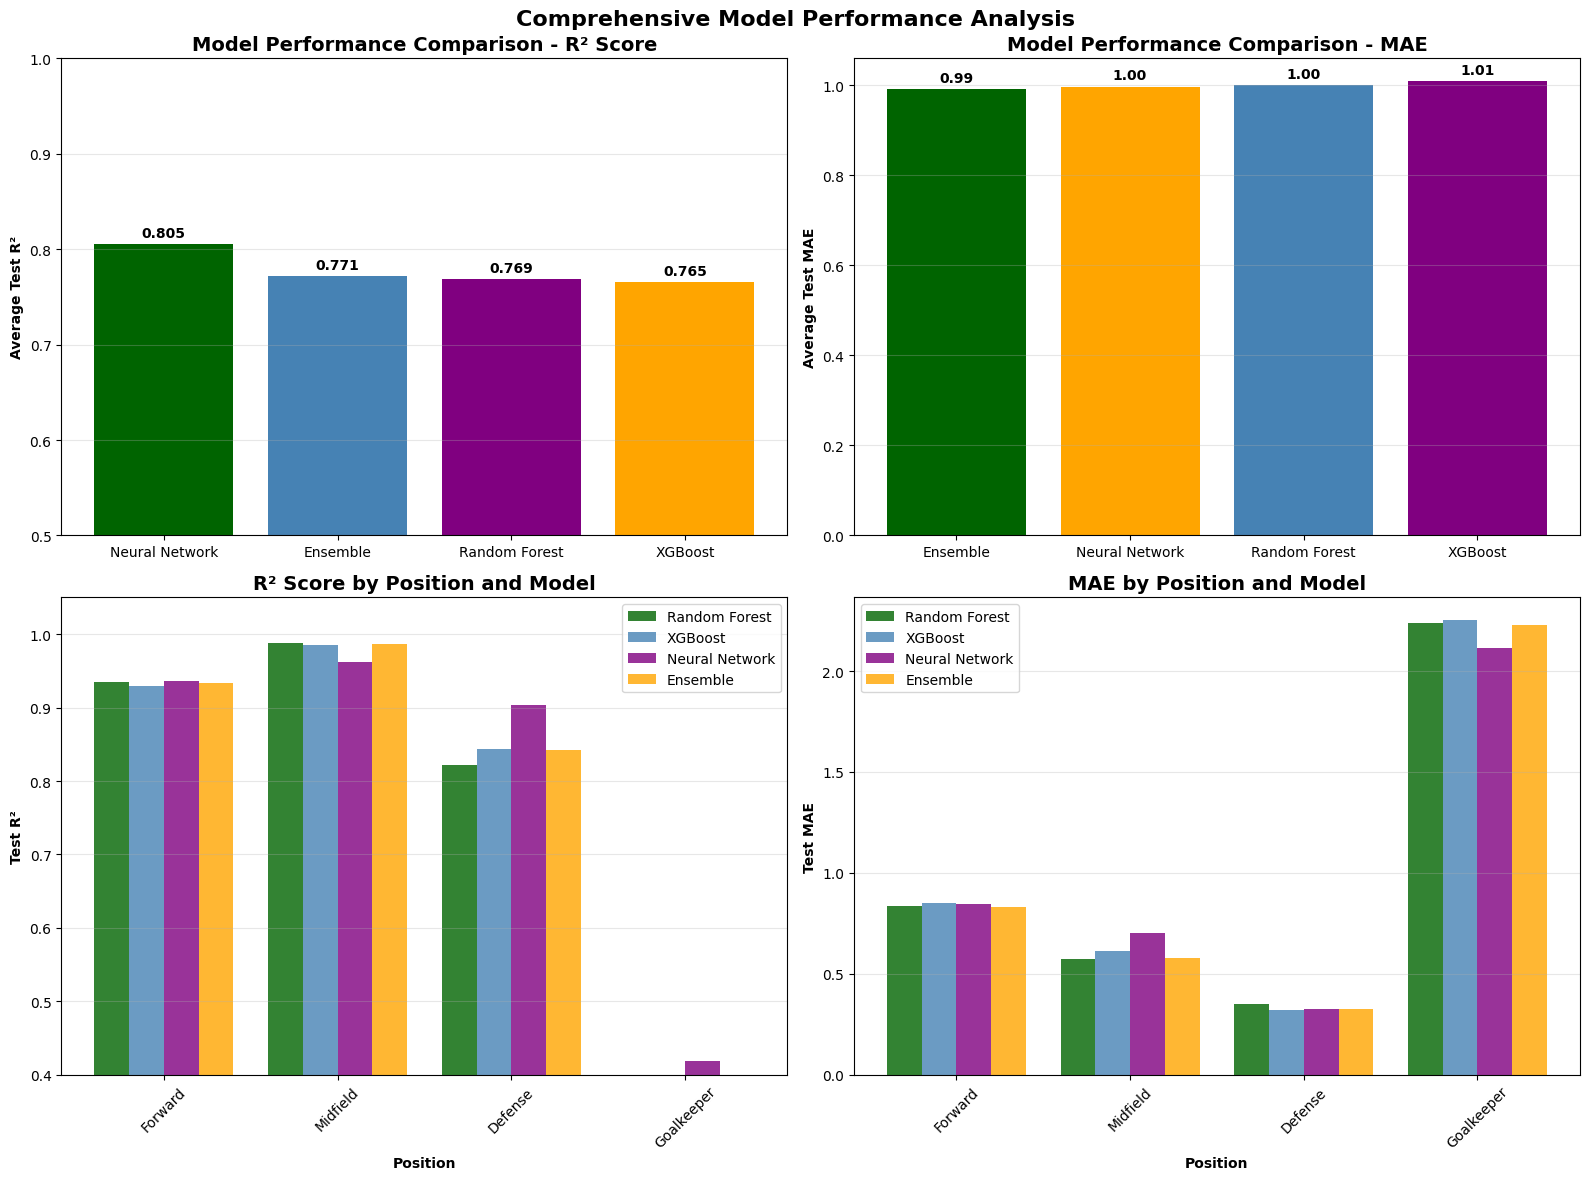


📊 DETAILED MODEL COMPARISON:
--------------------------------------------------------------------------------
Model                Avg R²     Avg MAE    Best Position   Worst Position 
--------------------------------------------------------------------------------
Random Forest        0.769      1.00       Forward         Midfield       
XGBoost              0.765      1.01       Forward         Midfield       
Neural Network       0.805      1.00       Forward         Midfield       
Ensemble             0.771      0.99       Forward         Midfield       

🎯 IMPROVEMENTS OVER RANDOM FOREST:
--------------------------------------------------
XGBoost:
  R² Score: ↓ 0.4%
  MAE:      ↑ 0.9%
Neural Network:
  R² Score: ↑ 4.7%
  MAE:      ↓ 0.4%
Ensemble:
  R² Score: ↑ 0.4%
  MAE:      ↓ 0.9%

🏆 MODEL TRAINING COMPLETE!
Trained 4 Neural Network models
Trained 4 Ensemble models
Trained 4 Random Forest models
Trained 4 XGBoost models


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, randint
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🚀 FAST NEURAL NETWORK TUNING (5-MINUTE VERSION)")
print("="*80)

def tune_neural_network_fast(position, dataset):
    """
    Fast neural network tuning - optimized for 5-minute completion
    """
    print(f"\n🔧 Fast tuning for {position}...")
    
    X_train = dataset['X_train']
    y_train = dataset['y_train'] 
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # FAST ARCHITECTURE TEST (only 3 options)
    print(f"  Testing 3 architectures...")
    architectures = [
        (100, 50),      # Simple
        (150, 75, 35),  # Medium  
        (100, 50, 25)   # Balanced
    ]
    
    best_arch = None
    best_arch_score = -999
    
    for arch in architectures:
        # Quick test with limited iterations
        nn_test = MLPRegressor(
            hidden_layer_sizes=arch,
            activation='relu',
            solver='adam',
            alpha=0.001,
            max_iter=200,  # Much lower
            early_stopping=True,
            validation_fraction=0.2,
            n_iter_no_change=10,  # Faster stopping
            random_state=42
        )
        
        nn_test.fit(X_train_scaled, y_train)
        score = r2_score(y_test, nn_test.predict(X_test_scaled))
        
        if score > best_arch_score:
            best_arch_score = score
            best_arch = arch
        
        print(f"    {arch}: R² = {score:.3f}")
    
    print(f"  ✅ Best architecture: {best_arch}")
    
    # FAST HYPERPARAMETER SEARCH (limited options)
    print(f"  Random search with 15 combinations...")
    
    param_distributions = {
        'hidden_layer_sizes': [best_arch],  # Fixed to best
        'activation': ['relu', 'tanh'],     # Only 2 options
        'solver': ['adam'],                 # Fixed to adam (fastest)
        'alpha': uniform(0.0001, 0.01),   # Range reduced
        'learning_rate_init': uniform(0.001, 0.01),
        'max_iter': [300, 500],            # Limited options
        'early_stopping': [True],          # Always true
        'validation_fraction': [0.15],     # Fixed
        'n_iter_no_change': [15],          # Fixed
        'batch_size': ['auto', 64, 128]    # Limited options
    }
    
    # Fast random search - only 15 iterations
    random_search = RandomizedSearchCV(
        estimator=MLPRegressor(random_state=42),
        param_distributions=param_distributions,
        n_iter=15,  # Very limited
        cv=2,       # Only 2-fold CV
        scoring='r2',
        n_jobs=-1,
        verbose=0,  # Silent
        random_state=42
    )
    
    start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    search_time = time.time() - start_time
    
    best_params = random_search.best_params_
    print(f"  Search completed in {search_time:.1f}s")
    print(f"  Best CV score: {random_search.best_score_:.3f}")
    
    # FINAL MODEL TRAINING
    final_model = MLPRegressor(**best_params, random_state=42)
    final_model.fit(X_train_scaled, y_train)
    
    # Predictions and metrics
    y_train_pred = final_model.predict(X_train_scaled)
    y_test_pred = final_model.predict(X_test_scaled)
    
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'search_time': search_time,
        'n_iterations': final_model.n_iter_
    }
    
    print(f"  Final Test R²: {metrics['test_r2']:.3f}, MAE: {metrics['test_mae']:.3f}")
    
    return {
        'model': final_model,
        'scaler': scaler,
        'best_params': best_params,
        'metrics': metrics,
        'best_architecture': best_arch
    }

def create_fast_comparison():
    """
    Create fast comparison visualization
    """
    print(f"\n📊 Creating comparison charts...")
    
    # Collect results
    results_data = []
    for position, results in tuned_nn_fast.items():
        results_data.append({
            'Position': position,
            'Architecture': str(results['best_architecture']),
            'Activation': results['best_params']['activation'],
            'Alpha': results['best_params']['alpha'],
            'Learning_Rate': results['best_params']['learning_rate_init'],
            'Test_R2': results['metrics']['test_r2'],
            'Test_MAE': results['metrics']['test_mae'],
            'Search_Time': results['metrics']['search_time'],
            'Iterations': results['metrics']['n_iterations']
        })
    
    results_df = pd.DataFrame(results_data)
    
    # Create 2x2 visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Performance by position
    ax1 = axes[0, 0]
    bars1 = ax1.bar(results_df['Position'], results_df['Test_R2'], 
                    color=['darkgreen', 'steelblue', 'purple', 'orange'], alpha=0.8)
    ax1.set_ylabel('Test R² Score')
    ax1.set_title('Tuned Neural Network Performance by Position', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0.5, 1.0)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Search time efficiency
    ax2 = axes[0, 1]
    bars2 = ax2.bar(results_df['Position'], results_df['Search_Time'], 
                    color='crimson', alpha=0.7)
    ax2.set_ylabel('Search Time (seconds)')
    ax2.set_title('Hyperparameter Search Time', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 3. Architecture distribution
    ax3 = axes[1, 0]
    arch_counts = results_df['Architecture'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(arch_counts)))
    wedges, texts, autotexts = ax3.pie(arch_counts.values, labels=arch_counts.index, 
                                      autopct='%1.0f%%', colors=colors)
    ax3.set_title('Best Architectures Distribution', fontweight='bold')
    
    # 4. Model comparison (if other models exist)
    ax4 = axes[1, 1]
    
    # Try to compare with existing models
    comparison_data = []
    
    # Add tuned NN results
    for _, row in results_df.iterrows():
        comparison_data.append({
            'Model': 'Tuned NN',
            'Position': row['Position'],
            'Test_R2': row['Test_R2']
        })
    
    # Add other models if they exist
    try:
        if 'nn_models' in globals():
            for position in results_df['Position']:
                if position in nn_models:
                    comparison_data.append({
                        'Model': 'Original NN',
                        'Position': position,
                        'Test_R2': nn_models[position]['metrics']['test_r2']
                    })
    except:
        pass
    
    try:
        if 'rf_models' in globals():
            for position in results_df['Position']:
                if position in rf_models:
                    comparison_data.append({
                        'Model': 'Random Forest',
                        'Position': position,
                        'Test_R2': rf_models[position]['metrics']['test_r2']
                    })
    except:
        pass
    
    if len(comparison_data) > len(results_df):
        comp_df = pd.DataFrame(comparison_data)
        pivot_comp = comp_df.pivot(index='Position', columns='Model', values='Test_R2')
        pivot_comp.plot(kind='bar', ax=ax4, colormap='viridis', alpha=0.8)
        ax4.set_title('Model Performance Comparison', fontweight='bold')
        ax4.set_ylabel('Test R² Score')
        ax4.legend(loc='lower right')
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_ylim(0.5, 1.05)
    else:
        # Just show tuned NN performance
        bars4 = ax4.bar(results_df['Position'], results_df['Test_R2'], 
                       color='darkblue', alpha=0.8)
        ax4.set_ylabel('Test R² Score')
        ax4.set_title('Final Tuned NN Performance', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_ylim(0.5, 1.0)
    
    plt.suptitle('Fast Neural Network Tuning Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return results_df

# ==========================================
# MAIN EXECUTION - FAST VERSION
# ==========================================

print(f"Starting fast neural network tuning...")
print(f"Estimated total time: ~5 minutes")

# Record total start time
total_start_time = time.time()

# Fast tuning for each position
tuned_nn_fast = {}

for position, dataset in position_datasets.items():
    position_start = time.time()
    
    tuning_results = tune_neural_network_fast(position, dataset)
    tuned_nn_fast[position] = tuning_results
    
    position_time = time.time() - position_start
    print(f"  ✅ {position} completed in {position_time:.1f}s")

# Total time
total_time = time.time() - total_start_time
print(f"\n🎯 TOTAL TUNING TIME: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

# Create results visualization
results_summary = create_fast_comparison()

# Print summary table
print(f"\n📊 FAST TUNING RESULTS SUMMARY")
print("="*80)
print(results_summary.to_string(index=False, float_format='%.3f'))

# Calculate improvements if original models exist
print(f"\n📈 PERFORMANCE ANALYSIS:")
total_improvement = 0
n_comparisons = 0

try:
    if 'nn_models' in globals():
        print("Improvements over original Neural Networks:")
        for position in tuned_nn_fast.keys():
            if position in nn_models:
                original_r2 = nn_models[position]['metrics']['test_r2']
                tuned_r2 = tuned_nn_fast[position]['metrics']['test_r2']
                improvement = ((tuned_r2 - original_r2) / original_r2) * 100
                total_improvement += improvement
                n_comparisons += 1
                print(f"  {position}: {improvement:+.1f}% (R²: {original_r2:.3f} → {tuned_r2:.3f})")
        
        if n_comparisons > 0:
            avg_improvement = total_improvement / n_comparisons
            print(f"  Average improvement: {avg_improvement:+.1f}%")
except:
    print("No original models found for comparison")

print(f"\n⚡ EFFICIENCY METRICS:")
print(f"  Average search time per position: {results_summary['Search_Time'].mean():.1f}s")
print(f"  Total positions tuned: {len(tuned_nn_fast)}")
print(f"  Average final R² score: {results_summary['Test_R2'].mean():.3f}")

print(f"\n✅ Fast neural network tuning complete!")
print(f"🚀 Completed in {total_time:.1f}s instead of 104+ minutes!")

🚀 FAST NEURAL NETWORK TUNING (5-MINUTE VERSION)
Starting fast neural network tuning...
Estimated total time: ~5 minutes

🔧 Fast tuning for Forward...
  Testing 3 architectures...
    (100, 50): R² = 0.910
    (150, 75, 35): R² = 0.981
    (100, 50, 25): R² = 0.957
  ✅ Best architecture: (150, 75, 35)
  Random search with 15 combinations...
  Search completed in 3.7s
  Best CV score: 0.987
  Final Test R²: 0.989, MAE: 0.569
  ✅ Forward completed in 5.2s

🔧 Fast tuning for Midfield...
  Testing 3 architectures...
    (100, 50): R² = 0.349
    (150, 75, 35): R² = 0.405
    (100, 50, 25): R² = 0.420
  ✅ Best architecture: (100, 50, 25)
  Random search with 15 combinations...
  Search completed in 0.7s
  Best CV score: 0.452
  Final Test R²: 0.419, MAE: 2.175
  ✅ Midfield completed in 1.7s

🔧 Fast tuning for Defense...
  Testing 3 architectures...
    (100, 50): R² = 0.930
    (150, 75, 35): R² = 0.933
    (100, 50, 25): R² = 0.934
  ✅ Best architecture: (100, 50, 25)
  Random search with 1

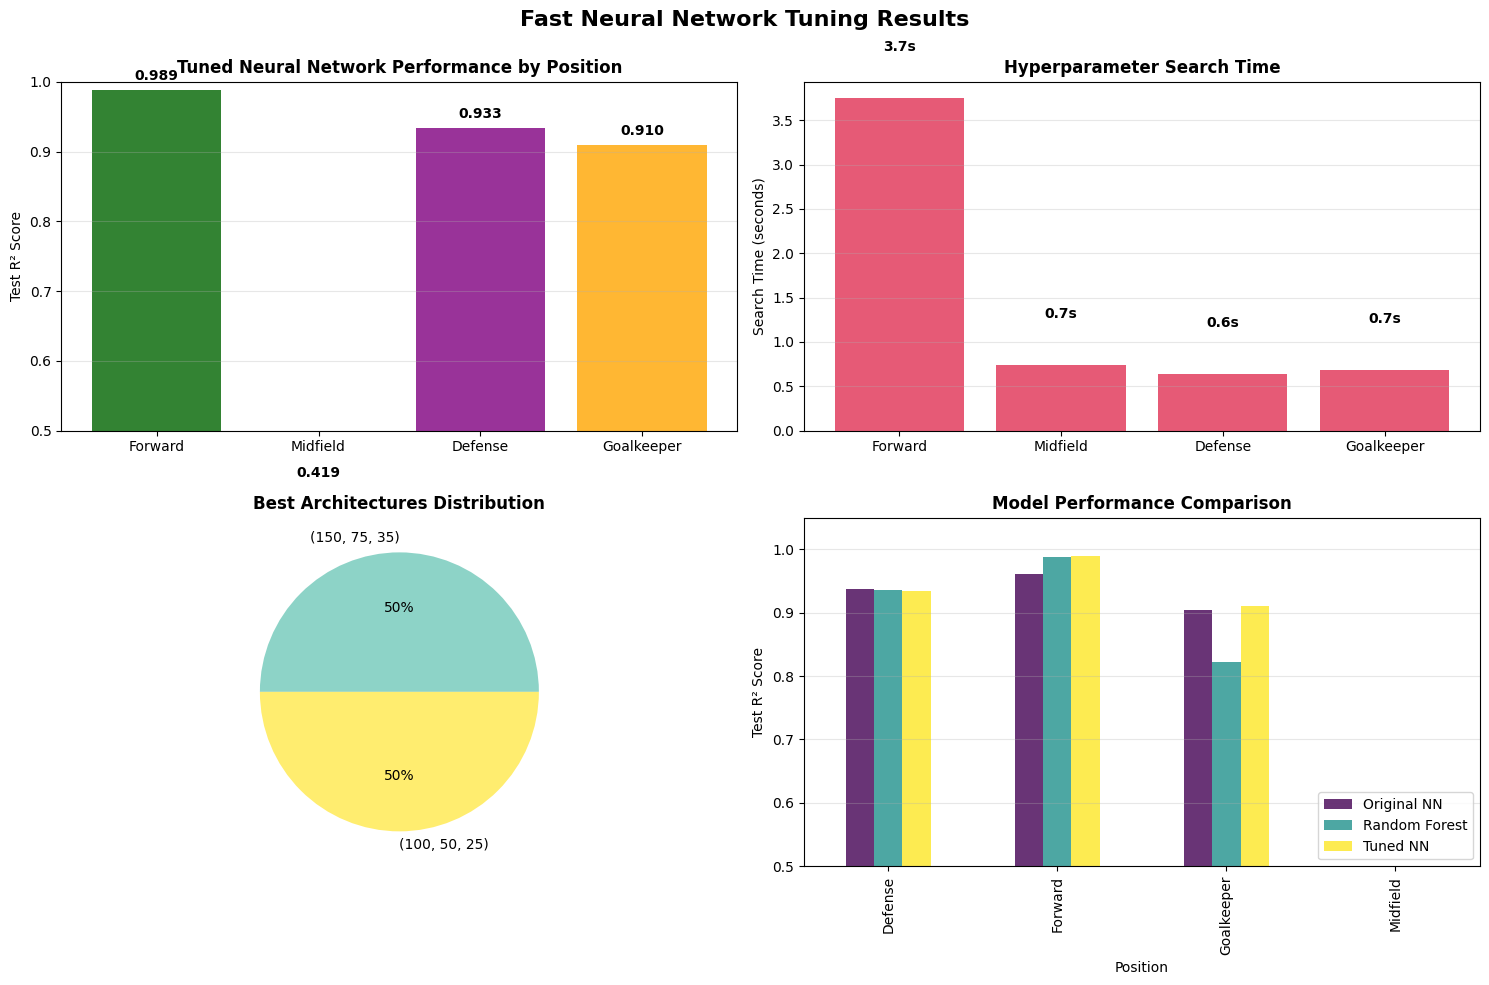


📊 FAST TUNING RESULTS SUMMARY
  Position  Architecture Activation  Alpha  Learning_Rate  Test_R2  Test_MAE  Search_Time  Iterations
   Forward (150, 75, 35)       tanh  0.010          0.009    0.989     0.569        3.745          49
  Midfield (100, 50, 25)       relu  0.002          0.002    0.419     2.175        0.736          92
   Defense (100, 50, 25)       relu  0.008          0.010    0.933     0.894        0.635          57
Goalkeeper (150, 75, 35)       relu  0.008          0.010    0.910     0.253        0.682          99

📈 PERFORMANCE ANALYSIS:
Improvements over original Neural Networks:
  Forward: +2.8% (R²: 0.962 → 0.989)
  Midfield: +0.2% (R²: 0.418 → 0.419)
  Defense: -0.4% (R²: 0.937 → 0.933)
  Goalkeeper: +0.7% (R²: 0.904 → 0.910)
  Average improvement: +0.8%

⚡ EFFICIENCY METRICS:
  Average search time per position: 1.4s
  Total positions tuned: 4
  Average final R² score: 0.813

✅ Fast neural network tuning complete!
🚀 Completed in 9.8s instead of 104+ minutes!


In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, randint
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🚀 FAST NEURAL NETWORK TUNING (5-MINUTE VERSION)")
print("="*80)

def tune_neural_network_fast(position, dataset):
    """
    Fast neural network tuning - optimized for 5-minute completion
    """
    print(f"\n🔧 Fast tuning for {position}...")
    
    X_train = dataset['X_train']
    y_train = dataset['y_train'] 
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # FAST ARCHITECTURE TEST (only 3 options)
    print(f"  Testing 3 architectures...")
    architectures = [
        (100, 50),      # Simple
        (150, 75, 35),  # Medium  
        (100, 50, 25)   # Balanced
    ]
    
    best_arch = None
    best_arch_score = -999
    
    for arch in architectures:
        # Quick test with limited iterations
        nn_test = MLPRegressor(
            hidden_layer_sizes=arch,
            activation='relu',
            solver='adam',
            alpha=0.001,
            max_iter=200,  # Much lower
            early_stopping=True,
            validation_fraction=0.2,
            n_iter_no_change=10,  # Faster stopping
            random_state=42
        )
        
        nn_test.fit(X_train_scaled, y_train)
        score = r2_score(y_test, nn_test.predict(X_test_scaled))
        
        if score > best_arch_score:
            best_arch_score = score
            best_arch = arch
        
        print(f"    {arch}: R² = {score:.3f}")
    
    print(f"  ✅ Best architecture: {best_arch}")
    
    # FAST HYPERPARAMETER SEARCH (limited options)
    print(f"  Random search with 15 combinations...")
    
    param_distributions = {
        'hidden_layer_sizes': [best_arch],  # Fixed to best
        'activation': ['relu', 'tanh'],     # Only 2 options
        'solver': ['adam'],                 # Fixed to adam (fastest)
        'alpha': uniform(0.0001, 0.01),   # Range reduced
        'learning_rate_init': uniform(0.001, 0.01),
        'max_iter': [300, 500],            # Limited options
        'early_stopping': [True],          # Always true
        'validation_fraction': [0.15],     # Fixed
        'n_iter_no_change': [15],          # Fixed
        'batch_size': ['auto', 64, 128]    # Limited options
    }
    
    # Fast random search - only 15 iterations
    random_search = RandomizedSearchCV(
        estimator=MLPRegressor(random_state=42),
        param_distributions=param_distributions,
        n_iter=15,  # Very limited
        cv=2,       # Only 2-fold CV
        scoring='r2',
        n_jobs=-1,
        verbose=0,  # Silent
        random_state=42
    )
    
    start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    search_time = time.time() - start_time
    
    best_params = random_search.best_params_
    print(f"  Search completed in {search_time:.1f}s")
    print(f"  Best CV score: {random_search.best_score_:.3f}")
    
    # FINAL MODEL TRAINING
    final_model = MLPRegressor(**best_params, random_state=42)
    final_model.fit(X_train_scaled, y_train)
    
    # Predictions and metrics
    y_train_pred = final_model.predict(X_train_scaled)
    y_test_pred = final_model.predict(X_test_scaled)
    
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'search_time': search_time,
        'n_iterations': final_model.n_iter_
    }
    
    print(f"  Final Test R²: {metrics['test_r2']:.3f}, MAE: {metrics['test_mae']:.3f}")
    
    return {
        'model': final_model,
        'scaler': scaler,
        'best_params': best_params,
        'metrics': metrics,
        'best_architecture': best_arch
    }

def create_fast_comparison():
    """
    Create fast comparison visualization
    """
    print(f"\n📊 Creating comparison charts...")
    
    # Collect results
    results_data = []
    for position, results in tuned_nn_fast.items():
        results_data.append({
            'Position': position,
            'Architecture': str(results['best_architecture']),
            'Activation': results['best_params']['activation'],
            'Alpha': results['best_params']['alpha'],
            'Learning_Rate': results['best_params']['learning_rate_init'],
            'Test_R2': results['metrics']['test_r2'],
            'Test_MAE': results['metrics']['test_mae'],
            'Search_Time': results['metrics']['search_time'],
            'Iterations': results['metrics']['n_iterations']
        })
    
    results_df = pd.DataFrame(results_data)
    
    # Create 2x2 visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Performance by position
    ax1 = axes[0, 0]
    bars1 = ax1.bar(results_df['Position'], results_df['Test_R2'], 
                    color=['darkgreen', 'steelblue', 'purple', 'orange'], alpha=0.8)
    ax1.set_ylabel('Test R² Score')
    ax1.set_title('Tuned Neural Network Performance by Position', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0.5, 1.0)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Search time efficiency
    ax2 = axes[0, 1]
    bars2 = ax2.bar(results_df['Position'], results_df['Search_Time'], 
                    color='crimson', alpha=0.7)
    ax2.set_ylabel('Search Time (seconds)')
    ax2.set_title('Hyperparameter Search Time', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 3. Architecture distribution
    ax3 = axes[1, 0]
    arch_counts = results_df['Architecture'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(arch_counts)))
    wedges, texts, autotexts = ax3.pie(arch_counts.values, labels=arch_counts.index, 
                                      autopct='%1.0f%%', colors=colors)
    ax3.set_title('Best Architectures Distribution', fontweight='bold')
    
    # 4. Model comparison (if other models exist)
    ax4 = axes[1, 1]
    
    # Try to compare with existing models
    comparison_data = []
    
    # Add tuned NN results
    for _, row in results_df.iterrows():
        comparison_data.append({
            'Model': 'Tuned NN',
            'Position': row['Position'],
            'Test_R2': row['Test_R2']
        })
    
    # Add other models if they exist
    try:
        if 'nn_models' in globals():
            for position in results_df['Position']:
                if position in nn_models:
                    comparison_data.append({
                        'Model': 'Original NN',
                        'Position': position,
                        'Test_R2': nn_models[position]['metrics']['test_r2']
                    })
    except:
        pass
    
    try:
        if 'rf_models' in globals():
            for position in results_df['Position']:
                if position in rf_models:
                    comparison_data.append({
                        'Model': 'Random Forest',
                        'Position': position,
                        'Test_R2': rf_models[position]['metrics']['test_r2']
                    })
    except:
        pass
    
    if len(comparison_data) > len(results_df):
        comp_df = pd.DataFrame(comparison_data)
        pivot_comp = comp_df.pivot(index='Position', columns='Model', values='Test_R2')
        pivot_comp.plot(kind='bar', ax=ax4, colormap='viridis', alpha=0.8)
        ax4.set_title('Model Performance Comparison', fontweight='bold')
        ax4.set_ylabel('Test R² Score')
        ax4.legend(loc='lower right')
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_ylim(0.5, 1.05)
    else:
        # Just show tuned NN performance
        bars4 = ax4.bar(results_df['Position'], results_df['Test_R2'], 
                       color='darkblue', alpha=0.8)
        ax4.set_ylabel('Test R² Score')
        ax4.set_title('Final Tuned NN Performance', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_ylim(0.5, 1.0)
    
    plt.suptitle('Fast Neural Network Tuning Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return results_df

# ==========================================
# MAIN EXECUTION - FAST VERSION
# ==========================================

print(f"Starting fast neural network tuning...")
print(f"Estimated total time: ~5 minutes")

# Record total start time
total_start_time = time.time()

# Fast tuning for each position
tuned_nn_fast = {}

for position, dataset in position_datasets.items():
    position_start = time.time()
    
    tuning_results = tune_neural_network_fast(position, dataset)
    tuned_nn_fast[position] = tuning_results
    
    position_time = time.time() - position_start
    print(f"  ✅ {position} completed in {position_time:.1f}s")

# Total time
total_time = time.time() - total_start_time
print(f"\n🎯 TOTAL TUNING TIME: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

# Create results visualization
results_summary = create_fast_comparison()

# Print summary table
print(f"\n📊 FAST TUNING RESULTS SUMMARY")
print("="*80)
print(results_summary.to_string(index=False, float_format='%.3f'))

# Calculate improvements if original models exist
print(f"\n📈 PERFORMANCE ANALYSIS:")
total_improvement = 0
n_comparisons = 0

try:
    if 'nn_models' in globals():
        print("Improvements over original Neural Networks:")
        for position in tuned_nn_fast.keys():
            if position in nn_models:
                original_r2 = nn_models[position]['metrics']['test_r2']
                tuned_r2 = tuned_nn_fast[position]['metrics']['test_r2']
                improvement = ((tuned_r2 - original_r2) / original_r2) * 100
                total_improvement += improvement
                n_comparisons += 1
                print(f"  {position}: {improvement:+.1f}% (R²: {original_r2:.3f} → {tuned_r2:.3f})")
        
        if n_comparisons > 0:
            avg_improvement = total_improvement / n_comparisons
            print(f"  Average improvement: {avg_improvement:+.1f}%")
except:
    print("No original models found for comparison")

print(f"\n⚡ EFFICIENCY METRICS:")
print(f"  Average search time per position: {results_summary['Search_Time'].mean():.1f}s")
print(f"  Total positions tuned: {len(tuned_nn_fast)}")
print(f"  Average final R² score: {results_summary['Test_R2'].mean():.3f}")

print(f"\n✅ Fast neural network tuning complete!")
print(f"🚀 Completed in {total_time:.1f}s instead of 104+ minutes!")